In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Statistical Hypothesis Testing with Kernels

## Maximum Mean Discrepancy: do X and Y have the same distribution?

Let's suppose we are given two sets of samples $\{X_1, \ldots, X_N\}$ and $\{Y_1, \ldots, Y_M\}$ draw iid from distributions $\mathbb{P}_X$ and $\mathbb{P}_Y$ respectively. 

We'd like to know whether in fact $\mathbb{P}_X$ and $\mathbb{P}_Y$ are the same distribution. We can do this using the kernel mean embedding.

The idea is this: embed the samples $X_n$ and $Y_m$ into an RKHS and look at their means $\tilde{\mu}_X$ and $\tilde{\mu}_Y$. As $N$ and $M$ become large, these means will converge to the mean embeddings of $\mathbb{P}_X$ and $\mathbb{P}_Y$ ($\mu_X$ and $\mu_Y$). Provided that we use a _characteristic_ kernel, the mean embeddings of $\mu_X$ and $\mu_Y$ will be equal if and only if the distributions are themselves equal. Of course, we only have access to finite samples, and so even if $\mathbb{P}_X$ and $\mathbb{P}_Y$ were equal, it would be very unlikely that the empirical embeddings $\tilde{\mu}_X$ and $\tilde{\mu}_Y$ would be equal, so we'll then have to do some clever sampling method to find the distribution of this difference under the hypothesis that $\mathbb{P}_X$ and $\mathbb{P}_Y$ are equal.

Given a kernel $k$, the mean embeddings are defined as

$$
\begin{align*}
\mu_X &= \mathbb{E}_{X\sim\mathbb{P}_X} k(X, \cdot) \\
\mu_Y &= \mathbb{E}_{Y\sim\mathbb{P}_Y} k(Y, \cdot) 
\end{align*}
$$

The empirical embeddings are

$$
\begin{align*}
\tilde{\mu}_X &= \frac{1}{N}\sum_n k(X_n, \cdot) \\
\tilde{\mu}_Y &= \frac{1}{M}\sum_m k(Y_m, \cdot) 
\end{align*}
$$

The RKHS distance between these two can actually be evaluated:

$$
\begin{align*}
\|\tilde{\mu}_X - \tilde{\mu}_Y\|^2_{\mathcal{H}_k} &= \langle \tilde{\mu}_X, \tilde{\mu}_X \rangle - 2 \langle \tilde{\mu}_X, \tilde{\mu}_Y \rangle + \langle \tilde{\mu}_Y, \tilde{\mu}_Y \rangle \\
&= \frac{1}{N^2}\sum_{n,n'} k(X_n, X_{n'}) - \frac{2}{NM}\sum_{n,m} k(X_n, Y_m)  + \frac{1}{M^2}\sum_{m,m'} k(Y_m, Y_{m'})\\
\end{align*}
$$

Note: this will be a biased estimator because of the fact that in the $XX$ and $YY$ terms there are $N$ and $M$ terms where the same datum appears in both the left and right argument.

So if we construct a big matrix $K$ with entries

$$
K = 
\begin{pmatrix}
K_{XX} & K_{YX} \\
K_{XY} & K_{YY}
\end{pmatrix}
$$

then our test statistic is just the averages of the diagonal blocks minus the averages of the off-diagonal blocks.

This is known as the MMD (maximum mean discrepancy)

In [271]:
def gaussian_kernel(Z, length):
    # Z.shape = [N, K]
    # broadcasts Z to be NxKx1 tensor, Z.T to be 1xKxN
    Z = Z[:,:,None]
    # then Z - Z.T is NxKxN, and we sum over the data dimension K (axis=1)
    pre_exp = ((Z - Z.T)**2).sum(axis=1)
    
    
    return np.exp(-(pre_exp / length))

def MMD(X, Y, kernel, kernel_parameters):
    N = len(X)
    M = len(Y)
    Z = np.concatenate([X, Y])
    K = kernel(Z, kernel_parameters)

    KXX = K[0:N, 0:N]
    KXY = K[N:, 0:N]
    KYY = K[N:, N:]
    
    return (KXX.sum()/(N**2))  - (2*KXY.sum()/(N*M)) + (KYY.sum()/(M**2))
     

def MMD_test(X, Y, kernel, kernel_parameters):
    mmd = MMD(X, Y, kernel, kernel_parameters)
    n_samples = 100
    null_dist = MMD_null(X, Y, kernel, kernel_parameters, n_samples)
    p_value = (null_dist[:,None] > mmd).sum() / float(n_samples)
    
    return mmd, p_value

def MMD_null(X, Y, kernel, kernel_parameters, n_samples):
    S = [False for _ in range(n_samples)]
    Z = np.concatenate([X,Y])
    for i in range(n_samples):
        np.random.shuffle(Z)
        S[i] = MMD(Z[0:len(X)], Z[len(X):], kernel, kernel_parameters)
    S = np.array(S)    
    return S

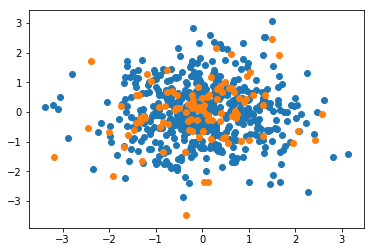

An MMD at least this large would occur with probability 0.13 under the hypothesis that the two distributions are the same.


In [272]:
X = np.random.randn(500,2)
Y = np.random.randn(100,2) + 0.

plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])
plt.show()

mmd, p_value =  MMD_test(X, Y, gaussian_kernel, 1)
print "An MMD at least this large would occur with probability " + str(p_value) + \
" under the hypothesis that the two distributions are the same."

## Hilbert Schmidt Independence Criterion: are X and Y independent?

We can use a very similar methodology for independence testing.

Suppose we are given samples $(X_i,Y_i)$, $i=1,\ldots,N$ draw from the joint distribution $\mathbb{P}_{XY}$. We want to know whether $X$ and $Y$ are independent. Equivalently, we can ask whether $\mathbb{P}_{XY} = \mathbb{P}_{X}\mathbb{P}_{Y}$.

It can be shown that if we have kernels $k$ and $l$ over $\mathcal{X}$ and $\mathcal{Y}$ respectively, then $k \otimes l$ is a kernel on $\mathcal{X}\times \mathcal{Y}$. We can write the mean embedding of $\mathbb{P}_{XY}$ with this kernel as $\mu_{XY}$. 

It can also be shown that if $\mathbb{P}_{XY} = \mathbb{P}_{X}\mathbb{P}_{Y}$ then $\mu_{XY} = \mu_{X}\otimes \mu_{Y}$.



We have empirical estimates for the above quantities:

$$
\tilde{\mu}_{XY} = \frac{1}{N} \sum_{n=1}^N k(X_n, \cdot) l(Y_n, \cdot)
$$

$$
\tilde{\mu}_{X}\otimes\tilde{\mu}_Y = \frac{1}{N} \sum_{n=1}^N k(X_n, \cdot)  \frac{1}{N} \sum_{m=1}^N l(Y_{m}, \cdot)
$$


Our test statistic will be 

$$
\begin{align*}
\| \tilde{\mu}_{XY} - \tilde{\mu}_{X}\otimes\tilde{\mu}_Y \|^2 &= \langle \tilde{\mu}_{XY}, \tilde{\mu}_{XY}\rangle - 2 \langle \tilde{\mu}_{XY}, \tilde{\mu}_{X}\otimes\tilde{\mu}_Y\rangle + \langle \tilde{\mu}_{X}\otimes\tilde{\mu}_Y, \tilde{\mu}_{X}\otimes\tilde{\mu}_Y\rangle \\
&= \frac{1}{N^2} \sum_{n,m} k(X_n,X_m)l(Y_n,Y_m) - \frac{2}{N^3}\sum_{n,m,s} k(X_n,X_m)l(X_n,X_s) + \frac{1}{N^4}\sum_{n,m,s,t} k(X_n,X_m)l(X_s,X_t)\\
\end{align*}
$$

We'll write $K$ and $L$ for the matrices with entries $K_{ij} = k(X_i, X_j)$ and $L_{ij} = l(Y_i, Y_j)$.

We will also write $M_{++}$ for the sum of all of the entries of the matrix $M$, $\circ$ for the Hadamard (aka element-wise) product (e.g. $K\circ L$) and $M_{+}$ for the vector with entries $(M_{+})_i = \sum_n M_{in}$

Using this abbreviated notation, we can express the above quantities more succinctly:

$$
\begin{align*}
\| \tilde{\mu}_{XY} - \tilde{\mu}_{X}\otimes\tilde{\mu}_Y \|^2 &= \frac{1}{N^2} (K\circ L)_{++} - \frac{2}{N^3} (K_{+}\circ L_{+})_{+}  + \frac{1}{N^4} K_{++} L_{++}\\
\end{align*}
$$

This test statistic is known as HSIC (Hilbert Schmidt Independence Criterion).

As before, we won't expect in the finite-sample case that this statistic will actually be equal to $0$ even if $X$ and $Y$ are independent. We need to see if it is _significantly far away from zero_ under the hypothesis of independence. We can simulate draws under the hypothesis of independence by applying a permutation to the indices of one of the $X_i$ or $Y_i$.

That is, we can generate lots of permutations $\pi$ of the integers $1,\ldots,N$ and calculate HSIC using the dataset $(X_{\pi(i)}, Y_i)$ and get a p-value for our actual sample of data.

In [188]:
K = np.random.randn(5,5)

In [194]:
( K.sum(axis=1) * K.sum(axis=1) ).sum()

17.860681577107975

In [362]:
def HSIC(X, Y, kernel_X, parameters_X, kernel_Y, parameters_Y, null=False):
    if null is True:
        X = np.random.permutation(X)
    K = kernel_X(X, parameters_X)
    L = kernel_Y(Y, parameters_Y)
    N = len(X)
    
    hsic = ( (K*L).sum() / float(N**2) ) - ( 2 * (K.sum(axis=1) * L.sum(axis=1)).sum() / float(N**3) ) + ( K.sum() * L.sum() / float(N**4) )
    return hsic

def HSIC_test(X, Y, kernel_X, parameters_X, kernel_Y, parameters_Y):
    hsic = HSIC(X, Y, kernel_X, parameters_X, kernel_Y, parameters_Y, null=False)
    
    n_samples = 1000
    null_distribution = [False for _ in range(n_samples)]
    for i in range(n_samples):
        null_distribution[i] = HSIC(X, Y, kernel_X, parameters_X, kernel_Y, parameters_Y, null=True)
    null_distribution = np.array(null_distribution)    
    p_value = ( null_distribution > np.array(hsic) ).sum() / float(n_samples)
    return p_value

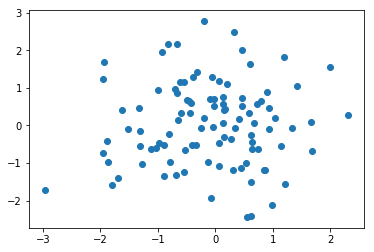

The probability of HSIC being its size or larger under the hypothesis that X and Y are independent is 0.295


In [368]:
X = np.random.randn(100,1)[:, None]
Y = np.random.randn(100,1)[:, None]

p_value = HSIC_test(X, Y, gaussian_kernel, 1, gaussian_kernel, 1)

plt.scatter(X[:,0], Y[:,0])
plt.show()
print "The probability of HSIC being its size or larger under the hypothesis that X and Y are independent is " + str(p_value)

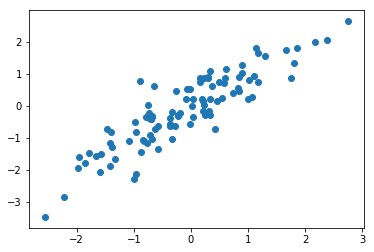

The probability of HSIC being its size or larger under the hypothesis that X and Y are independent is 0.0


In [372]:
X = np.random.randn(100,1)[:, None]
Y = X + 0.5*np.random.randn(100,1)[:,None]

p_value = HSIC_test(X, Y, gaussian_kernel, 1, gaussian_kernel, 1)

plt.scatter(X[:,0], Y[:,0])
plt.show()
print "The probability of HSIC being its size or larger under the hypothesis that X and Y are independent is " + str(p_value)